In [1]:
import torch
import clip
from PIL import Image

!pip uninstall numpy -y
!pip install "numpy<2" --force-reinstall
import numpy as np
print(np.__version__) 

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
1.26.4


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset = datasets.ImageFolder(
    root="data",
    transform=preprocess
)

# DataLoader for batching
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [4]:
import matplotlib.pyplot as plt


all_embeddings = []
with torch.no_grad():
    for images, _ in dataloader:  # we ignore class labels
        images = images.to(device)
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)
        all_embeddings.append(features)

embeddings = torch.cat(all_embeddings, dim=0)

In [5]:
import sys
print(sys.executable)

/Users/darpalpatel/Projects/NavAssistant/ramvenv/bin/python


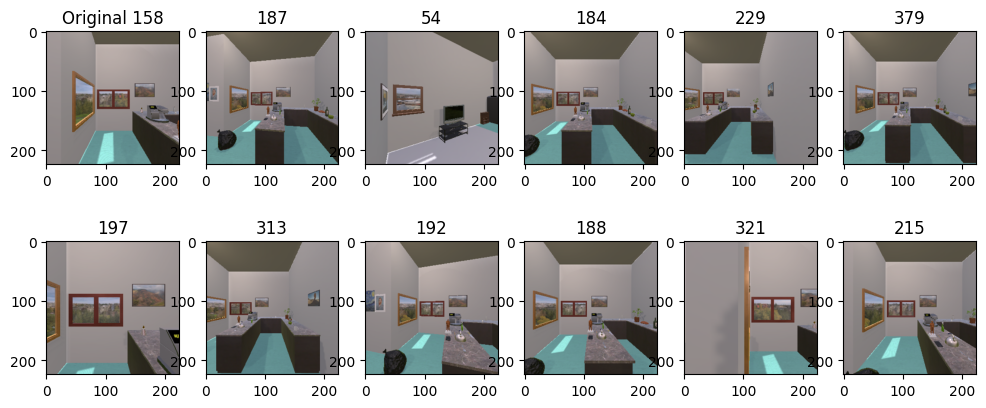

In [7]:
embeddings_norm = embeddings / torch.norm(embeddings, dim=1, keepdim=True)

query_idx = torch.randint(0, len(dataset), (1,))[0]
query = embeddings_norm[query_idx]
similarities = embeddings_norm @ query  # shape (N,)

k = 11
topk_idx = similarities.argsort()[-k-1:-1]

CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073])
CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711])

def denormalize(tensor):
    """
    Undo CLIP preprocessing normalization.
    Input: torch tensor of shape (3, H, W)
    Output: numpy array in [0,1] range
    """
    img = tensor * CLIP_STD[:, None, None] + CLIP_MEAN[:, None, None]
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

image, _ = dataset[query_idx]
i = 1
plt.figure(figsize=(k + 1,5))
plt.subplot(2, int((k + 1) / 2), i)
plt.imshow(denormalize(image))
plt.title(f"Original {query_idx}")
i += 1
for idx in topk_idx:
    plt.subplot(2, int((k + 1) / 2), i)
    image, _ = dataset[idx]
    plt.imshow(denormalize(image))
    plt.title(str(idx.item()))
    i += 1
plt.show()

In [8]:
#check transfomers== 4.25.1 and timm=0.4.12
import pkg_resources

required_packages = [
    "timm",
    "transformers",
    "fairscale",
    "pycocoevalcap",
    "torch",
    "torchvision",
    "Pillow",
    "scipy",
    "clip"
]

for package in required_packages:
    try:
        dist = pkg_resources.get_distribution(package)
        print(f"{package}: {dist.version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package}: NOT INSTALLED")

timm: 0.4.12
transformers: 4.25.1
fairscale: 0.4.4
pycocoevalcap: 1.2
torch: 2.9.1
torchvision: 0.24.1
Pillow: 12.0.0
scipy: 1.15.3
clip: 1.0


/var/folders/_7/zhxrcnb92sd44n2lh08mdcn00000gn/T/ipykernel_47101/1966636760.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
from ram.models import ram, tag2text
from ram import inference_ram, get_transform
from torchvision.transforms.functional import to_pil_image

/Users/darpalpatel/Projects/NavAssistant/ramvenv/lib/python3.10/site-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/Users/darpalpatel/Projects/NavAssistant/ramvenv/lib/python3.10/site-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ram(pretrained=None, image_size=384, vit='swin_l')

#replace with your local path (wget did not work for me)
#https://huggingface.co/spaces/xinyu1205/recognize-anything/blob/main/ram_swin_large_14m.pth
checkpoint = torch.load(
    '/Users/darpalpatel/Projects/NavAssistant/ram_swin_large_14m.pth',
    map_location=device,
)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval().to(device)

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied


RAM(
  (visual_encoder): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=192, input_resolution=(96, 96), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=192, input_resolution=(96, 96), num_heads=6, window_size=12, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=192, window_size=(12, 12), num_heads=6
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-

In [11]:
#check the speed of RAM applied to video
from ram.models import ram, tag2text
from ram import inference_ram, get_transform
from torchvision.transforms.functional import to_pil_image
import torch
import numpy as np
from tqdm import tqdm

In [12]:
import cv2
vid = cv2.VideoCapture('/Users/darpalpatel/Projects/NavAssistant/rollout_go_room.mp4')
frames = []
while True:
    ok, frame = vid.read()
    if not ok: break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [13]:
transform = get_transform(image_size=384) 
tag_dict = tag2text()

television_mask = [] 

for idx, frame_rgb in enumerate(tqdm(frames, desc="Processing frames with RAM")):
    frame_pil = to_pil_image(frame_rgb)
    frame_tensor = transform(frame_pil).unsqueeze(0).to(device) 
    
    with torch.no_grad():
        tags, _ = inference_ram(frame_tensor, model)
    
    
    if 'television' in tags: 
        television_mask.append(1)
        print(tags)
    else:
        television_mask.append(0)
    
    print(f"Frame {idx}: television detected = {television_mask[-1]}")



/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied


Processing frames with RAM:   0%|          | 1/256 [00:16<1:09:41, 16.40s/it]

Frame 0: television detected = 0


Processing frames with RAM:   1%|          | 2/256 [00:17<31:31,  7.45s/it]  

Frame 1: television detected = 0


Processing frames with RAM:   1%|          | 3/256 [00:18<18:47,  4.46s/it]

Frame 2: television detected = 0


Processing frames with RAM:   2%|▏         | 4/256 [00:20<13:57,  3.32s/it]

Frame 3: television detected = 0


Processing frames with RAM:   2%|▏         | 5/256 [00:21<11:14,  2.69s/it]

Frame 4: television detected = 0


Processing frames with RAM:   2%|▏         | 6/256 [00:23<10:08,  2.44s/it]

Frame 5: television detected = 0


Processing frames with RAM:   3%|▎         | 7/256 [00:24<08:40,  2.09s/it]

Frame 6: television detected = 0


Processing frames with RAM:   3%|▎         | 8/256 [00:26<07:48,  1.89s/it]

Frame 7: television detected = 0


Processing frames with RAM:   4%|▎         | 9/256 [00:27<06:57,  1.69s/it]

Frame 8: television detected = 0


Processing frames with RAM:   4%|▍         | 10/256 [00:28<06:13,  1.52s/it]

Frame 9: television detected = 0


Processing frames with RAM:   4%|▍         | 11/256 [00:30<06:09,  1.51s/it]

Frame 10: television detected = 0


Processing frames with RAM:   5%|▍         | 12/256 [00:31<05:49,  1.43s/it]

Frame 11: television detected = 0


Processing frames with RAM:   5%|▌         | 13/256 [00:32<05:12,  1.28s/it]

Frame 12: television detected = 0


Processing frames with RAM:   5%|▌         | 14/256 [00:33<04:48,  1.19s/it]

Frame 13: television detected = 0


Processing frames with RAM:   6%|▌         | 15/256 [00:34<04:38,  1.16s/it]

Frame 14: television detected = 0


Processing frames with RAM:   6%|▋         | 16/256 [00:35<04:14,  1.06s/it]

Frame 15: television detected = 0


Processing frames with RAM:   7%|▋         | 17/256 [00:36<04:40,  1.18s/it]

Frame 16: television detected = 0


Processing frames with RAM:   7%|▋         | 18/256 [00:38<05:12,  1.31s/it]

Frame 17: television detected = 0


Processing frames with RAM:   7%|▋         | 19/256 [00:40<06:11,  1.57s/it]

Frame 18: television detected = 0


Processing frames with RAM:   8%|▊         | 20/256 [00:41<05:45,  1.47s/it]

Frame 19: television detected = 0


Processing frames with RAM:   8%|▊         | 21/256 [00:42<05:15,  1.34s/it]

Frame 20: television detected = 0


Processing frames with RAM:   9%|▊         | 22/256 [00:44<05:05,  1.30s/it]

Frame 21: television detected = 0


Processing frames with RAM:   9%|▉         | 23/256 [00:44<04:31,  1.17s/it]

Frame 22: television detected = 0


Processing frames with RAM:   9%|▉         | 24/256 [00:45<04:13,  1.09s/it]

Frame 23: television detected = 0


Processing frames with RAM:  10%|▉         | 25/256 [00:46<04:02,  1.05s/it]

Frame 24: television detected = 0


Processing frames with RAM:  10%|█         | 26/256 [00:48<04:57,  1.29s/it]

Frame 25: television detected = 0


Processing frames with RAM:  11%|█         | 27/256 [00:49<04:43,  1.24s/it]

Frame 26: television detected = 0


Processing frames with RAM:  11%|█         | 28/256 [00:50<04:08,  1.09s/it]

Frame 27: television detected = 0


Processing frames with RAM:  11%|█▏        | 29/256 [00:51<03:45,  1.01it/s]

Frame 28: television detected = 0


Processing frames with RAM:  12%|█▏        | 30/256 [00:52<03:25,  1.10it/s]

Frame 29: television detected = 0


Processing frames with RAM:  12%|█▏        | 31/256 [00:52<03:12,  1.17it/s]

Frame 30: television detected = 0


Processing frames with RAM:  12%|█▎        | 32/256 [00:53<03:08,  1.19it/s]

Frame 31: television detected = 0


Processing frames with RAM:  13%|█▎        | 33/256 [00:54<03:09,  1.18it/s]

Frame 32: television detected = 0


Processing frames with RAM:  13%|█▎        | 34/256 [00:55<03:03,  1.21it/s]

Frame 33: television detected = 0


Processing frames with RAM:  14%|█▎        | 35/256 [00:55<02:57,  1.25it/s]

Frame 34: television detected = 0


Processing frames with RAM:  14%|█▍        | 36/256 [00:56<02:54,  1.26it/s]

Frame 35: television detected = 0


Processing frames with RAM:  14%|█▍        | 37/256 [00:57<02:53,  1.26it/s]

Frame 36: television detected = 0


Processing frames with RAM:  15%|█▍        | 38/256 [00:58<02:55,  1.25it/s]

Frame 37: television detected = 0


Processing frames with RAM:  15%|█▌        | 39/256 [00:59<02:59,  1.21it/s]

Frame 38: television detected = 0


Processing frames with RAM:  16%|█▌        | 40/256 [01:00<03:06,  1.16it/s]

Frame 39: television detected = 0


Processing frames with RAM:  16%|█▌        | 41/256 [01:00<03:02,  1.18it/s]

Frame 40: television detected = 0


Processing frames with RAM:  16%|█▋        | 42/256 [01:01<02:59,  1.19it/s]

Frame 41: television detected = 0


Processing frames with RAM:  17%|█▋        | 43/256 [01:02<03:03,  1.16it/s]

Frame 42: television detected = 0


Processing frames with RAM:  17%|█▋        | 44/256 [01:03<03:06,  1.13it/s]

Frame 43: television detected = 0


Processing frames with RAM:  18%|█▊        | 45/256 [01:04<03:02,  1.15it/s]

Frame 44: television detected = 0


Processing frames with RAM:  18%|█▊        | 46/256 [01:05<02:58,  1.18it/s]

Frame 45: television detected = 0


Processing frames with RAM:  18%|█▊        | 47/256 [01:06<03:20,  1.04it/s]

Frame 46: television detected = 0


Processing frames with RAM:  19%|█▉        | 48/256 [01:07<03:15,  1.06it/s]

Frame 47: television detected = 0


Processing frames with RAM:  19%|█▉        | 49/256 [01:08<03:09,  1.09it/s]

Frame 48: television detected = 0


Processing frames with RAM:  20%|█▉        | 50/256 [01:09<03:04,  1.11it/s]

Frame 49: television detected = 0


Processing frames with RAM:  20%|█▉        | 51/256 [01:10<03:12,  1.07it/s]

Frame 50: television detected = 0


Processing frames with RAM:  20%|██        | 52/256 [01:11<03:08,  1.08it/s]

Frame 51: television detected = 0


Processing frames with RAM:  21%|██        | 53/256 [01:12<03:12,  1.05it/s]

Frame 52: television detected = 0


Processing frames with RAM:  21%|██        | 54/256 [01:13<03:22,  1.00s/it]

Frame 53: television detected = 0


Processing frames with RAM:  21%|██▏       | 55/256 [01:14<03:11,  1.05it/s]

Frame 54: television detected = 0


Processing frames with RAM:  22%|██▏       | 56/256 [01:15<03:23,  1.02s/it]

Frame 55: television detected = 0


Processing frames with RAM:  22%|██▏       | 57/256 [01:16<03:56,  1.19s/it]

Frame 56: television detected = 0


Processing frames with RAM:  23%|██▎       | 58/256 [01:17<03:52,  1.17s/it]

Frame 57: television detected = 0


Processing frames with RAM:  23%|██▎       | 59/256 [01:18<03:25,  1.04s/it]

Frame 58: television detected = 0


Processing frames with RAM:  23%|██▎       | 60/256 [01:19<03:06,  1.05it/s]

Frame 59: television detected = 0


Processing frames with RAM:  24%|██▍       | 61/256 [01:20<03:36,  1.11s/it]

Frame 60: television detected = 0


Processing frames with RAM:  24%|██▍       | 62/256 [01:22<03:43,  1.15s/it]

Frame 61: television detected = 0


Processing frames with RAM:  25%|██▍       | 63/256 [01:23<03:43,  1.16s/it]

Frame 62: television detected = 0


Processing frames with RAM:  25%|██▌       | 64/256 [01:24<03:29,  1.09s/it]

Frame 63: television detected = 0


Processing frames with RAM:  25%|██▌       | 65/256 [01:24<03:08,  1.01it/s]

Frame 64: television detected = 0


Processing frames with RAM:  26%|██▌       | 66/256 [01:25<02:53,  1.09it/s]

Frame 65: television detected = 0


Processing frames with RAM:  26%|██▌       | 67/256 [01:26<02:40,  1.18it/s]

Frame 66: television detected = 0


Processing frames with RAM:  27%|██▋       | 68/256 [01:27<02:33,  1.22it/s]

Frame 67: television detected = 0


Processing frames with RAM:  27%|██▋       | 69/256 [01:28<02:36,  1.20it/s]

Frame 68: television detected = 0


Processing frames with RAM:  27%|██▋       | 70/256 [01:29<02:55,  1.06it/s]

Frame 69: television detected = 0


Processing frames with RAM:  28%|██▊       | 71/256 [01:33<06:11,  2.01s/it]

Frame 70: television detected = 0


Processing frames with RAM:  28%|██▊       | 72/256 [01:38<08:22,  2.73s/it]

Frame 71: television detected = 0


Processing frames with RAM:  29%|██▊       | 73/256 [01:40<07:47,  2.56s/it]

Frame 72: television detected = 0


Processing frames with RAM:  29%|██▉       | 74/256 [01:42<07:25,  2.45s/it]

Frame 73: television detected = 0


Processing frames with RAM:  29%|██▉       | 75/256 [01:45<07:29,  2.48s/it]

Frame 74: television detected = 0


Processing frames with RAM:  30%|██▉       | 76/256 [01:46<06:51,  2.29s/it]

Frame 75: television detected = 0


Processing frames with RAM:  30%|███       | 77/256 [01:49<06:41,  2.24s/it]

Frame 76: television detected = 0


Processing frames with RAM:  30%|███       | 78/256 [01:51<06:36,  2.22s/it]

Frame 77: television detected = 0


Processing frames with RAM:  31%|███       | 79/256 [01:53<07:02,  2.39s/it]

Frame 78: television detected = 0


Processing frames with RAM:  31%|███▏      | 80/256 [01:57<07:39,  2.61s/it]

Frame 79: television detected = 0


Processing frames with RAM:  32%|███▏      | 81/256 [01:59<07:38,  2.62s/it]

Frame 80: television detected = 0


Processing frames with RAM:  32%|███▏      | 82/256 [02:03<08:22,  2.89s/it]

Frame 81: television detected = 0


Processing frames with RAM:  32%|███▏      | 83/256 [02:06<09:02,  3.14s/it]

Frame 82: television detected = 0


Processing frames with RAM:  33%|███▎      | 84/256 [02:10<09:35,  3.35s/it]

Frame 83: television detected = 0


Processing frames with RAM:  33%|███▎      | 85/256 [02:12<08:20,  2.93s/it]

Frame 84: television detected = 0


Processing frames with RAM:  34%|███▎      | 86/256 [02:14<07:28,  2.64s/it]

Frame 85: television detected = 0


Processing frames with RAM:  34%|███▍      | 87/256 [02:16<06:22,  2.26s/it]

Frame 86: television detected = 0


Processing frames with RAM:  34%|███▍      | 88/256 [02:17<05:29,  1.96s/it]

Frame 87: television detected = 0


Processing frames with RAM:  35%|███▍      | 89/256 [02:18<04:54,  1.76s/it]

Frame 88: television detected = 0


Processing frames with RAM:  35%|███▌      | 90/256 [02:19<04:11,  1.51s/it]

Frame 89: television detected = 0


Processing frames with RAM:  36%|███▌      | 91/256 [02:20<03:52,  1.41s/it]

Frame 90: television detected = 0


Processing frames with RAM:  36%|███▌      | 92/256 [02:21<03:28,  1.27s/it]

Frame 91: television detected = 0


Processing frames with RAM:  36%|███▋      | 93/256 [02:22<03:16,  1.21s/it]

Frame 92: television detected = 0


Processing frames with RAM:  37%|███▋      | 94/256 [02:23<03:05,  1.15s/it]

Frame 93: television detected = 0


Processing frames with RAM:  37%|███▋      | 95/256 [02:24<02:48,  1.04s/it]

Frame 94: television detected = 0


Processing frames with RAM:  38%|███▊      | 96/256 [02:25<02:36,  1.02it/s]

Frame 95: television detected = 0


Processing frames with RAM:  38%|███▊      | 97/256 [02:26<02:24,  1.10it/s]

Frame 96: television detected = 0


Processing frames with RAM:  38%|███▊      | 98/256 [02:27<02:31,  1.04it/s]

Frame 97: television detected = 0


Processing frames with RAM:  39%|███▊      | 99/256 [02:28<02:37,  1.00s/it]

Frame 98: television detected = 0


Processing frames with RAM:  39%|███▉      | 100/256 [02:29<02:37,  1.01s/it]

Frame 99: television detected = 0


Processing frames with RAM:  39%|███▉      | 101/256 [02:31<03:33,  1.38s/it]

Frame 100: television detected = 0


Processing frames with RAM:  40%|███▉      | 102/256 [02:32<03:15,  1.27s/it]

Frame 101: television detected = 0


Processing frames with RAM:  40%|████      | 103/256 [02:34<03:44,  1.47s/it]

Frame 102: television detected = 0


Processing frames with RAM:  41%|████      | 104/256 [02:35<03:40,  1.45s/it]

Frame 103: television detected = 0


Processing frames with RAM:  41%|████      | 105/256 [02:37<03:23,  1.35s/it]

wall | flat | hang | screen | television
Frame 104: television detected = 1


Processing frames with RAM:  41%|████▏     | 106/256 [02:37<03:00,  1.20s/it]

flat | ice cave | man | screen | television
Frame 105: television detected = 1


Processing frames with RAM:  42%|████▏     | 107/256 [02:38<02:42,  1.09s/it]

flat | ice cave | man | room | screen | television
Frame 106: television detected = 1


Processing frames with RAM:  42%|████▏     | 108/256 [02:40<02:51,  1.16s/it]

Frame 107: television detected = 0


Processing frames with RAM:  43%|████▎     | 109/256 [02:41<02:42,  1.11s/it]

flat | man | television
Frame 108: television detected = 1


Processing frames with RAM:  43%|████▎     | 110/256 [02:42<02:44,  1.13s/it]

wall | carpet | ceiling | flat | floor | living room | room | television
Frame 109: television detected = 1


Processing frames with RAM:  43%|████▎     | 111/256 [02:43<02:49,  1.17s/it]

Frame 110: television detected = 0


Processing frames with RAM:  44%|████▍     | 112/256 [02:44<02:55,  1.22s/it]

Frame 111: television detected = 0


Processing frames with RAM:  44%|████▍     | 113/256 [02:45<02:43,  1.14s/it]

Frame 112: television detected = 0


Processing frames with RAM:  45%|████▍     | 114/256 [02:47<02:49,  1.19s/it]

Frame 113: television detected = 0


Processing frames with RAM:  45%|████▍     | 115/256 [02:48<02:37,  1.12s/it]

Frame 114: television detected = 0


Processing frames with RAM:  45%|████▌     | 116/256 [02:49<02:41,  1.15s/it]

Frame 115: television detected = 0


Processing frames with RAM:  46%|████▌     | 117/256 [02:50<02:30,  1.09s/it]

Frame 116: television detected = 0


Processing frames with RAM:  46%|████▌     | 118/256 [02:51<02:24,  1.05s/it]

Frame 117: television detected = 0


Processing frames with RAM:  46%|████▋     | 119/256 [02:52<02:15,  1.01it/s]

Frame 118: television detected = 0


Processing frames with RAM:  47%|████▋     | 120/256 [02:53<02:37,  1.16s/it]

Frame 119: television detected = 0


Processing frames with RAM:  47%|████▋     | 121/256 [02:55<02:49,  1.26s/it]

Frame 120: television detected = 0


Processing frames with RAM:  48%|████▊     | 122/256 [02:56<02:51,  1.28s/it]

Frame 121: television detected = 0


Processing frames with RAM:  48%|████▊     | 123/256 [02:57<02:51,  1.29s/it]

wall | flat | hang | sea | screen | television
Frame 122: television detected = 1


Processing frames with RAM:  48%|████▊     | 124/256 [02:58<02:38,  1.20s/it]

wall | computer monitor | flat | hang | ice cave | room | screen | television
Frame 123: television detected = 1


Processing frames with RAM:  49%|████▉     | 125/256 [02:59<02:38,  1.21s/it]

Frame 124: television detected = 0


Processing frames with RAM:  49%|████▉     | 126/256 [03:01<02:35,  1.20s/it]

computer | computer monitor | computer screen | table | flat | office | room | screen | television
Frame 125: television detected = 1


Processing frames with RAM:  50%|████▉     | 127/256 [03:01<02:21,  1.10s/it]

ceiling | computer | computer monitor | computer screen | table | floor | office | office building | office cubicle | room | stool | television
Frame 126: television detected = 1


Processing frames with RAM:  50%|█████     | 128/256 [03:02<02:13,  1.04s/it]

blind | wall | carpet | ceiling | computer | computer monitor | doorway | flat | floor | office | office building | room | television
Frame 127: television detected = 1


Processing frames with RAM:  50%|█████     | 129/256 [03:03<02:08,  1.01s/it]

blind | wall | carpet | ceiling | computer | computer monitor | doorway | flat | floor | office | office building | room | television
Frame 128: television detected = 1


Processing frames with RAM:  51%|█████     | 130/256 [03:05<02:18,  1.10s/it]

blind | wall | carpet | ceiling | computer | computer monitor | doorway | flat | floor | office | office building | room | television
Frame 129: television detected = 1


Processing frames with RAM:  51%|█████     | 131/256 [03:06<02:10,  1.04s/it]

blind | wall | carpet | ceiling | computer | computer monitor | doorway | flat | floor | office | office building | room | television
Frame 130: television detected = 1


Processing frames with RAM:  52%|█████▏    | 132/256 [03:06<02:00,  1.03it/s]

Frame 131: television detected = 0


Processing frames with RAM:  52%|█████▏    | 133/256 [03:07<01:57,  1.05it/s]

Frame 132: television detected = 0


Processing frames with RAM:  52%|█████▏    | 134/256 [03:08<01:59,  1.02it/s]

Frame 133: television detected = 0


Processing frames with RAM:  53%|█████▎    | 135/256 [03:09<02:02,  1.01s/it]

Frame 134: television detected = 0


Processing frames with RAM:  53%|█████▎    | 136/256 [03:11<02:07,  1.07s/it]

Frame 135: television detected = 0


Processing frames with RAM:  54%|█████▎    | 137/256 [03:12<02:26,  1.23s/it]

Frame 136: television detected = 0


Processing frames with RAM:  54%|█████▍    | 138/256 [03:13<02:25,  1.23s/it]

Frame 137: television detected = 0


Processing frames with RAM:  54%|█████▍    | 139/256 [03:15<02:31,  1.29s/it]

Frame 138: television detected = 0


Processing frames with RAM:  55%|█████▍    | 140/256 [03:16<02:17,  1.19s/it]

Frame 139: television detected = 0


Processing frames with RAM:  55%|█████▌    | 141/256 [03:17<02:04,  1.08s/it]

Frame 140: television detected = 0


Processing frames with RAM:  55%|█████▌    | 142/256 [03:17<01:53,  1.00it/s]

Frame 141: television detected = 0


Processing frames with RAM:  56%|█████▌    | 143/256 [03:18<01:49,  1.03it/s]

Frame 142: television detected = 0


Processing frames with RAM:  56%|█████▋    | 144/256 [03:19<01:43,  1.08it/s]

Frame 143: television detected = 0


Processing frames with RAM:  57%|█████▋    | 145/256 [03:20<01:38,  1.12it/s]

Frame 144: television detected = 0


Processing frames with RAM:  57%|█████▋    | 146/256 [03:21<01:34,  1.16it/s]

Frame 145: television detected = 0


Processing frames with RAM:  57%|█████▋    | 147/256 [03:22<01:39,  1.09it/s]

Frame 146: television detected = 0


Processing frames with RAM:  58%|█████▊    | 148/256 [03:23<01:40,  1.08it/s]

Frame 147: television detected = 0


Processing frames with RAM:  58%|█████▊    | 149/256 [03:24<01:45,  1.01it/s]

Frame 148: television detected = 0


Processing frames with RAM:  59%|█████▊    | 150/256 [03:25<01:41,  1.04it/s]

Frame 149: television detected = 0


Processing frames with RAM:  59%|█████▉    | 151/256 [03:26<01:36,  1.09it/s]

Frame 150: television detected = 0


Processing frames with RAM:  59%|█████▉    | 152/256 [03:27<01:36,  1.08it/s]

Frame 151: television detected = 0


Processing frames with RAM:  60%|█████▉    | 153/256 [03:28<01:53,  1.10s/it]

Frame 152: television detected = 0


Processing frames with RAM:  60%|██████    | 154/256 [03:30<02:03,  1.21s/it]

Frame 153: television detected = 0


Processing frames with RAM:  61%|██████    | 155/256 [03:31<01:59,  1.19s/it]

Frame 154: television detected = 0


Processing frames with RAM:  61%|██████    | 156/256 [03:32<01:49,  1.10s/it]

Frame 155: television detected = 0


Processing frames with RAM:  61%|██████▏   | 157/256 [03:32<01:42,  1.04s/it]

Frame 156: television detected = 0


Processing frames with RAM:  62%|██████▏   | 158/256 [03:33<01:35,  1.02it/s]

Frame 157: television detected = 0


Processing frames with RAM:  62%|██████▏   | 159/256 [03:34<01:32,  1.05it/s]

Frame 158: television detected = 0


Processing frames with RAM:  62%|██████▎   | 160/256 [03:35<01:40,  1.04s/it]

Frame 159: television detected = 0


Processing frames with RAM:  63%|██████▎   | 161/256 [03:37<01:41,  1.07s/it]

wall | lamp | computer | doorway | floor | image | living room | room | speaker | stool | television
Frame 160: television detected = 1


Processing frames with RAM:  63%|██████▎   | 162/256 [03:38<01:37,  1.04s/it]

Frame 161: television detected = 0


Processing frames with RAM:  64%|██████▎   | 163/256 [03:39<01:34,  1.02s/it]

Frame 162: television detected = 0


Processing frames with RAM:  64%|██████▍   | 164/256 [03:39<01:26,  1.06it/s]

Frame 163: television detected = 0


Processing frames with RAM:  64%|██████▍   | 165/256 [03:40<01:25,  1.06it/s]

Frame 164: television detected = 0


Processing frames with RAM:  65%|██████▍   | 166/256 [03:42<01:40,  1.11s/it]

bed | bedroom | blue | carpet | ceiling | chair | computer | computer desk | table | floor | room | stool | television
Frame 165: television detected = 1


Processing frames with RAM:  65%|██████▌   | 167/256 [03:43<01:44,  1.18s/it]

Frame 166: television detected = 0


Processing frames with RAM:  66%|██████▌   | 168/256 [03:45<01:59,  1.36s/it]

Frame 167: television detected = 0


Processing frames with RAM:  66%|██████▌   | 169/256 [03:46<01:50,  1.27s/it]

Frame 168: television detected = 0


Processing frames with RAM:  66%|██████▋   | 170/256 [03:47<01:37,  1.13s/it]

Frame 169: television detected = 0


Processing frames with RAM:  67%|██████▋   | 171/256 [03:48<01:28,  1.04s/it]

Frame 170: television detected = 0


Processing frames with RAM:  67%|██████▋   | 172/256 [03:48<01:21,  1.03it/s]

Frame 171: television detected = 0


Processing frames with RAM:  68%|██████▊   | 173/256 [03:49<01:15,  1.10it/s]

Frame 172: television detected = 0


Processing frames with RAM:  68%|██████▊   | 174/256 [03:50<01:10,  1.16it/s]

Frame 173: television detected = 0


Processing frames with RAM:  68%|██████▊   | 175/256 [03:51<01:07,  1.19it/s]

Frame 174: television detected = 0


Processing frames with RAM:  69%|██████▉   | 176/256 [03:52<01:22,  1.03s/it]

Frame 175: television detected = 0


Processing frames with RAM:  69%|██████▉   | 177/256 [03:54<01:31,  1.15s/it]

Frame 176: television detected = 0


Processing frames with RAM:  70%|██████▉   | 178/256 [03:55<01:33,  1.19s/it]

Frame 177: television detected = 0


Processing frames with RAM:  70%|██████▉   | 179/256 [03:56<01:38,  1.28s/it]

Frame 178: television detected = 0


Processing frames with RAM:  70%|███████   | 180/256 [03:57<01:30,  1.19s/it]

Frame 179: television detected = 0


Processing frames with RAM:  71%|███████   | 181/256 [03:58<01:21,  1.09s/it]

Frame 180: television detected = 0


Processing frames with RAM:  71%|███████   | 182/256 [03:59<01:15,  1.03s/it]

Frame 181: television detected = 0


Processing frames with RAM:  71%|███████▏  | 183/256 [04:00<01:10,  1.03it/s]

Frame 182: television detected = 0


Processing frames with RAM:  72%|███████▏  | 184/256 [04:01<01:06,  1.08it/s]

Frame 183: television detected = 0


Processing frames with RAM:  72%|███████▏  | 185/256 [04:02<01:05,  1.08it/s]

Frame 184: television detected = 0


Processing frames with RAM:  73%|███████▎  | 186/256 [04:02<01:01,  1.13it/s]

wall | lamp | cave | fireplace | flat | ice cave | living room | room | television
Frame 185: television detected = 1


Processing frames with RAM:  73%|███████▎  | 187/256 [04:03<01:00,  1.14it/s]

Frame 186: television detected = 0


Processing frames with RAM:  73%|███████▎  | 188/256 [04:04<00:58,  1.17it/s]

wall | carpet | ceiling | computer | doorway | flat | floor | lead to | room | television
Frame 187: television detected = 1


Processing frames with RAM:  74%|███████▍  | 189/256 [04:05<00:55,  1.21it/s]

Frame 188: television detected = 0


Processing frames with RAM:  74%|███████▍  | 190/256 [04:06<00:52,  1.26it/s]

Frame 189: television detected = 0


Processing frames with RAM:  75%|███████▍  | 191/256 [04:06<00:50,  1.28it/s]

Frame 190: television detected = 0


Processing frames with RAM:  75%|███████▌  | 192/256 [04:07<00:49,  1.30it/s]

Frame 191: television detected = 0


Processing frames with RAM:  75%|███████▌  | 193/256 [04:08<00:47,  1.32it/s]

Frame 192: television detected = 0


Processing frames with RAM:  76%|███████▌  | 194/256 [04:09<00:46,  1.34it/s]

Frame 193: television detected = 0


Processing frames with RAM:  76%|███████▌  | 195/256 [04:09<00:45,  1.35it/s]

Frame 194: television detected = 0


Processing frames with RAM:  77%|███████▋  | 196/256 [04:10<00:44,  1.35it/s]

Frame 195: television detected = 0


Processing frames with RAM:  77%|███████▋  | 197/256 [04:11<00:43,  1.36it/s]

Frame 196: television detected = 0


Processing frames with RAM:  77%|███████▋  | 198/256 [04:11<00:43,  1.35it/s]

Frame 197: television detected = 0


Processing frames with RAM:  78%|███████▊  | 199/256 [04:12<00:42,  1.34it/s]

Frame 198: television detected = 0


Processing frames with RAM:  78%|███████▊  | 200/256 [04:13<00:41,  1.34it/s]

Frame 199: television detected = 0


Processing frames with RAM:  79%|███████▊  | 201/256 [04:14<00:41,  1.33it/s]

Frame 200: television detected = 0


Processing frames with RAM:  79%|███████▉  | 202/256 [04:14<00:40,  1.34it/s]

Frame 201: television detected = 0


Processing frames with RAM:  79%|███████▉  | 203/256 [04:15<00:39,  1.33it/s]

Frame 202: television detected = 0


Processing frames with RAM:  80%|███████▉  | 204/256 [04:16<00:38,  1.36it/s]

Frame 203: television detected = 0


Processing frames with RAM:  80%|████████  | 205/256 [04:17<00:37,  1.37it/s]

Frame 204: television detected = 0


Processing frames with RAM:  80%|████████  | 206/256 [04:17<00:36,  1.36it/s]

Frame 205: television detected = 0


Processing frames with RAM:  81%|████████  | 207/256 [04:18<00:36,  1.35it/s]

Frame 206: television detected = 0


Processing frames with RAM:  81%|████████▏ | 208/256 [04:19<00:38,  1.25it/s]

Frame 207: television detected = 0


Processing frames with RAM:  82%|████████▏ | 209/256 [04:20<00:39,  1.20it/s]

Frame 208: television detected = 0


Processing frames with RAM:  82%|████████▏ | 210/256 [04:21<00:40,  1.14it/s]

Frame 209: television detected = 0


Processing frames with RAM:  82%|████████▏ | 211/256 [04:22<00:41,  1.09it/s]

Frame 210: television detected = 0


Processing frames with RAM:  83%|████████▎ | 212/256 [04:23<00:45,  1.03s/it]

Frame 211: television detected = 0


Processing frames with RAM:  83%|████████▎ | 213/256 [04:25<00:48,  1.13s/it]

Frame 212: television detected = 0


Processing frames with RAM:  84%|████████▎ | 214/256 [04:26<00:45,  1.08s/it]

Frame 213: television detected = 0


Processing frames with RAM:  84%|████████▍ | 215/256 [04:27<00:42,  1.05s/it]

Frame 214: television detected = 0


Processing frames with RAM:  84%|████████▍ | 216/256 [04:27<00:40,  1.01s/it]

Frame 215: television detected = 0


Processing frames with RAM:  85%|████████▍ | 217/256 [04:29<00:39,  1.02s/it]

Frame 216: television detected = 0


Processing frames with RAM:  85%|████████▌ | 218/256 [04:30<00:38,  1.02s/it]

Frame 217: television detected = 0


Processing frames with RAM:  86%|████████▌ | 219/256 [04:30<00:36,  1.00it/s]

Frame 218: television detected = 0


Processing frames with RAM:  86%|████████▌ | 220/256 [04:31<00:35,  1.02it/s]

Frame 219: television detected = 0


Processing frames with RAM:  86%|████████▋ | 221/256 [04:32<00:32,  1.08it/s]

Frame 220: television detected = 0


Processing frames with RAM:  87%|████████▋ | 222/256 [04:33<00:30,  1.13it/s]

Frame 221: television detected = 0


Processing frames with RAM:  87%|████████▋ | 223/256 [04:34<00:29,  1.11it/s]

Frame 222: television detected = 0


Processing frames with RAM:  88%|████████▊ | 224/256 [04:35<00:28,  1.11it/s]

Frame 223: television detected = 0


Processing frames with RAM:  88%|████████▊ | 225/256 [04:36<00:31,  1.01s/it]

Frame 224: television detected = 0


Processing frames with RAM:  88%|████████▊ | 226/256 [04:37<00:30,  1.02s/it]

Frame 225: television detected = 0


Processing frames with RAM:  89%|████████▊ | 227/256 [04:38<00:31,  1.08s/it]

Frame 226: television detected = 0


Processing frames with RAM:  89%|████████▉ | 228/256 [04:40<00:33,  1.20s/it]

Frame 227: television detected = 0


Processing frames with RAM:  89%|████████▉ | 229/256 [04:41<00:32,  1.20s/it]

Frame 228: television detected = 0


Processing frames with RAM:  90%|████████▉ | 230/256 [04:42<00:29,  1.12s/it]

Frame 229: television detected = 0


Processing frames with RAM:  90%|█████████ | 231/256 [04:43<00:26,  1.05s/it]

Frame 230: television detected = 0


Processing frames with RAM:  91%|█████████ | 232/256 [04:44<00:25,  1.06s/it]

Frame 231: television detected = 0


Processing frames with RAM:  91%|█████████ | 233/256 [04:45<00:27,  1.17s/it]

Frame 232: television detected = 0


Processing frames with RAM:  91%|█████████▏| 234/256 [04:47<00:25,  1.16s/it]

Frame 233: television detected = 0


Processing frames with RAM:  92%|█████████▏| 235/256 [04:47<00:22,  1.07s/it]

Frame 234: television detected = 0


Processing frames with RAM:  92%|█████████▏| 236/256 [04:48<00:20,  1.01s/it]

Frame 235: television detected = 0


Processing frames with RAM:  93%|█████████▎| 237/256 [04:49<00:18,  1.03it/s]

Frame 236: television detected = 0


Processing frames with RAM:  93%|█████████▎| 238/256 [04:50<00:16,  1.07it/s]

Frame 237: television detected = 0


Processing frames with RAM:  93%|█████████▎| 239/256 [04:51<00:15,  1.11it/s]

Frame 238: television detected = 0


Processing frames with RAM:  94%|█████████▍| 240/256 [04:52<00:14,  1.12it/s]

Frame 239: television detected = 0


Processing frames with RAM:  94%|█████████▍| 241/256 [04:53<00:13,  1.11it/s]

Frame 240: television detected = 0


Processing frames with RAM:  95%|█████████▍| 242/256 [04:54<00:12,  1.08it/s]

Frame 241: television detected = 0


Processing frames with RAM:  95%|█████████▍| 243/256 [04:55<00:13,  1.02s/it]

Frame 242: television detected = 0


Processing frames with RAM:  95%|█████████▌| 244/256 [04:57<00:14,  1.22s/it]

Frame 243: television detected = 0


Processing frames with RAM:  96%|█████████▌| 245/256 [04:58<00:12,  1.18s/it]

Frame 244: television detected = 0


Processing frames with RAM:  96%|█████████▌| 246/256 [04:58<00:10,  1.09s/it]

Frame 245: television detected = 0


Processing frames with RAM:  96%|█████████▋| 247/256 [04:59<00:09,  1.02s/it]

Frame 246: television detected = 0


Processing frames with RAM:  97%|█████████▋| 248/256 [05:00<00:07,  1.02it/s]

Frame 247: television detected = 0


Processing frames with RAM:  97%|█████████▋| 249/256 [05:01<00:06,  1.04it/s]

Frame 248: television detected = 0


Processing frames with RAM:  98%|█████████▊| 250/256 [05:02<00:05,  1.06it/s]

Frame 249: television detected = 0


Processing frames with RAM:  98%|█████████▊| 251/256 [05:03<00:04,  1.08it/s]

Frame 250: television detected = 0


Processing frames with RAM:  98%|█████████▊| 252/256 [05:04<00:03,  1.09it/s]

Frame 251: television detected = 0


Processing frames with RAM:  99%|█████████▉| 253/256 [05:05<00:02,  1.10it/s]

Frame 252: television detected = 0


Processing frames with RAM:  99%|█████████▉| 254/256 [05:06<00:01,  1.12it/s]

Frame 253: television detected = 0


Processing frames with RAM: 100%|█████████▉| 255/256 [05:07<00:01,  1.02s/it]

Frame 254: television detected = 0


Processing frames with RAM: 100%|██████████| 256/256 [05:08<00:00,  1.20s/it]

Frame 255: television detected = 0


torch.Size([257, 28])
Query image index: 95
Query tags: bottle | carpet | floor | room | stool

Top-k most similar frames:
 1. Image index: 199
   Tags: armchair | blue | carpet | chair | couch | table | dinning table | floor | furniture | hassock | living room | room | stool
 2. Image index: 82
   Tags: carpet | ceiling | chair | table | floor | furniture | hassock | image | living room | modern | photo | room | stool
 3. Image index: 396
   Tags: armchair | bedroom | carpet | chair | computer | computer desk | floor | furniture | hassock | living room | room | stool
 4. Image index: 51
   Tags: armchair | blue | carpet | ceiling | couch | fill | floor | furniture | hassock | living room | modern | room | stool | television
 5. Image index: 160
   Tags: armchair | bedroom | blue | carpet | chair | couch | floor | furniture | hassock | living room | room
 6. Image index: 386
   Tags: armchair | blue | carpet | ceiling | chair | couch | fill | floor | furniture | hassock | living room |

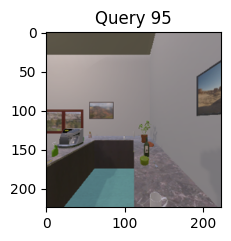

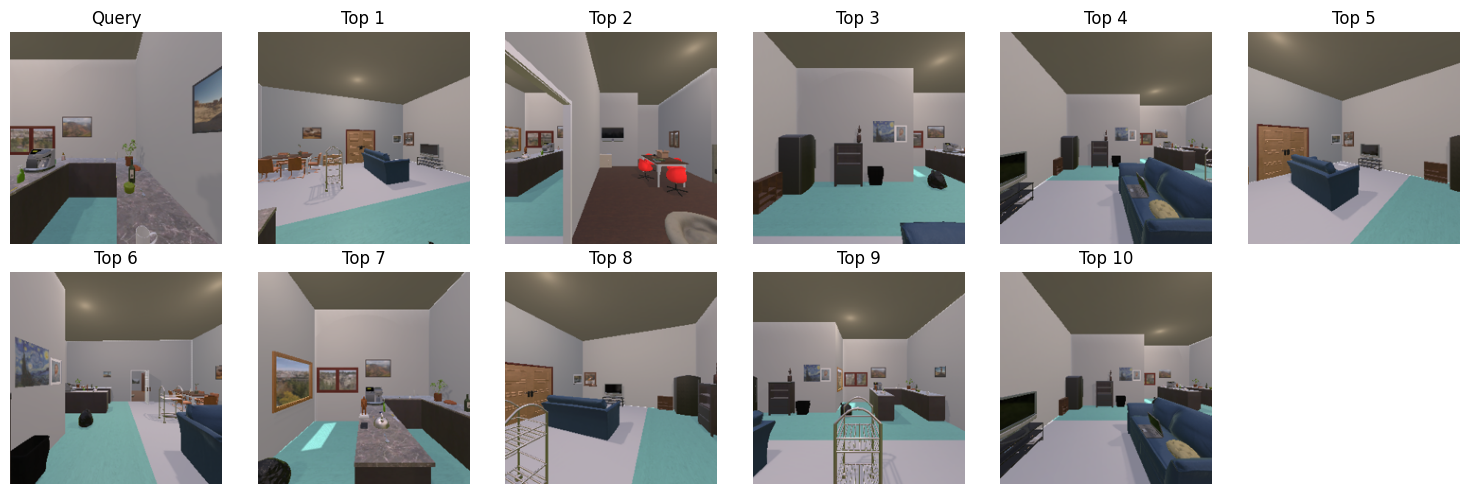

In [ ]:
query_id = torch.randint(0, len(dataset), (1,)).item()
query_vector = image_vectors_norm[query_id]

similarities = image_vectors_norm @ query_vector
topk = 10
topk_idx = similarities.argsort(descending=True)[1:topk+1]

print(image_vectors_norm.unique(dim=0).shape)

print(f"Query image index: {query_idx}")
print("Query tags:", dataset_tags[query_idx])
print("\nTop-k most similar frames:")
for rank, idx in enumerate(topk_idx, start=1):
    print(f"{rank:2d}. Image index: {idx.item()}")
    print("   Tags:", dataset_tags[idx.item()])

plt.figure(figsize=(15,5))
plt.subplot(2, (topk+1)//2, 1)
image, _ = dataset[query_idx]
plt.imshow(denormalize(image))
plt.title(f"Query {query_idx}")



plt.figure(figsize=(15,5))
for i, idx in enumerate([query_idx] + topk_idx.tolist()):
    plt.subplot(2, (topk + 1 + 1) // 2 , i + 1)
    image, _ = dataset[idx]
    plt.imshow(denormalize(image))
    title = "Query" if i == 0 else f"Top {i}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()